In [38]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot, inverse_transform_new

In [3]:
df = pd.read_excel('all_data.xlsx')

In [4]:
df.tail()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063
365,2024-02-29,62499.183594,63585.644531,60498.730469,61198.382813,65496611844,positif,92,61198.382813


# PREPROCESSING

In [5]:
df = df.drop(columns=['Date', 'Volume', 'Sentimen', 'Index'])

In [6]:
X = df.drop('Close', axis=1)
y = df['Close']

In [7]:
X, y, scaler = scale_data(df)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        elif n_lstm == 3:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        # Training the model
        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history  # Return the training history if successful
    except Exception as e:
        print(f"Error during model training: {e}")
        return None  # Return None if there was an error

# Loop to try different configurations
def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {}  # Dictionary to store results
    
    # Loop through all combinations of parameters
    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                # Store history of the model in a dictionary
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                # Only store history if it is not None
                if history is not None:
                    # Storing the MSE for train and test
                    mse_train = history.history['loss'][-1]  # Last epoch's training MSE
                    mse_test = history.history['val_loss'][-1]  # Last epoch's validation (test) MSE
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

# Example usage
lstm_configs = {
    'n_lstm': [1, 2],  # Number of LSTM layers
    'neurons': [50, 100, 150, 200],  # Number of neurons in each LSTM layer
    'epochs': [10, 20, 30]  # Number of epochs for training
}

In [11]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Train on 292 samples, validate on 73 samples
Epoch 1/10
292/292 [==============================] - 1s 3ms/sample - loss: 0.0379 - val_loss: 0.1093
Epoch 2/10
292/292 [==============================] - 0s 87us/sample - loss: 0.0155 - val_loss: 0.0356
Epoch 3/10
292/292 [==============================] - 0s 122us/sample - loss: 0.0155 - val_loss: 0.0806
Epoch 4/10
292/292 [==============================] - 0s 118us/sample - loss: 0.0137 - val_loss: 0.1088
Epoch 5/10
292/292 [==============================] - 0s 106us/sample - loss: 0.0136 - val_loss: 0.0959
Epoch 6/10
292/292 [==============================] - 0s 97us/sample - loss: 0.0130 - val_loss: 0.0931
Epoch 7/10
292/292 [==============================] - 0s 103us/sample - loss: 0.0128 - val_loss: 0.1134
Epoch 8/10
292/292 [==============================] - 0s 92us/sample - loss: 0.0128 - val_loss: 0.1094
Epoch 9/10
292/292 [==============================] - 0s 107us/sample - loss: 0

In [12]:
# Mengambil dan menyimpan nilai mse_train dan mse_test
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

# Menampilkan hasil
for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.012565712001149172, MSE Test: 0.12415252085009666
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012508936315672854, MSE Test: 0.13592067840572905
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.01233896775145645, MSE Test: 0.1453309573539316
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012363911057784133, MSE Test: 0.13717913872575108
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.012451092699823314, MSE Test: 0.14575971724235848
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.01235718412758553, MSE Test: 0.15096397983701262
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.012370689338302775, MSE Test: 0.12994909623306092
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.012674338962525537, MSE Test: 0.1471879145462219
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.01253910767144128, MSE Test: 0.16015735819731672
Experiment: n_lstm=1_neurons=200_epochs=10, M

In [13]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012566,0.124153
1,n_lstm=1_neurons=50_epochs=20,0.012509,0.135921
2,n_lstm=1_neurons=50_epochs=30,0.012339,0.145331
3,n_lstm=1_neurons=100_epochs=10,0.012364,0.137179
4,n_lstm=1_neurons=100_epochs=20,0.012451,0.145760
5,n_lstm=1_neurons=100_epochs=30,0.012357,0.150964
6,n_lstm=1_neurons=150_epochs=10,0.012371,0.129949
7,n_lstm=1_neurons=150_epochs=20,0.012674,0.147188
8,n_lstm=1_neurons=150_epochs=30,0.012539,0.160157
9,n_lstm=1_neurons=200_epochs=10,0.012486,0.119350


In [14]:
hp_lstm.to_excel("kombinasi-parameter-2.xlsx")

In [17]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=150_epochs=20
mse_train                            0.00029
mse_test                            0.000956
Name: 19, dtype: object


In [19]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=150_epochs=20
mse_train                            0.00029
mse_test                            0.000956
Name: 19, dtype: object


In [20]:
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=150))
model.add(Dense(25))
model.add(Dense(1)) 
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Train on 292 samples, validate on 73 samples
Epoch 1/10
292/292 [==============================] - 5s 18ms/sample - loss: 0.0353 - val_loss: 0.0964
Epoch 2/10
292/292 [==============================] - 0s 463us/sample - loss: 0.0072 - val_loss: 0.0251
Epoch 3/10
292/292 [==============================] - 0s 457us/sample - loss: 0.0052 - val_loss: 0.0675
Epoch 4/10
292/292 [==============================] - 0s 469us/sample - loss: 0.0040 - val_loss: 0.0214
Epoch 5/10
292/292 [==============================] - 0s 462us/sample - loss: 0.0021 - val_loss: 0.0101
Epoch 6/10
292/292 [==============================] - 0s 445us/sample - loss: 8.6074e-04 - val_loss: 0.0020
Epoch 7/10
292/292 [==============================] - 0s 461us/sample - loss: 3.3137e-04 - val_loss: 0.0014
Epoch 8/10
292/292 [==============================] - 0s 464us/sample - loss: 3.2620e-04 - val_loss: 0.0023
Epoch 9/10
292/292 [==============================] - 0s 463us/sample - loss: 3.5019e-04 - val_loss: 0.0010
Epoc

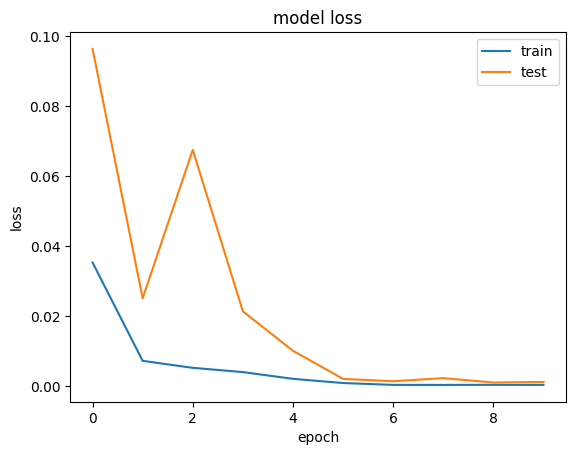

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [22]:
predictions_train = model.predict(X_train)
# Inverse transform predictions
inverse_predictions_train = inverse_transform(scaler, predictions_train)
# Inverse transform y_test
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

,Predicted,Actual
0,23884.471322,23475.466797
1,23958.140472,22362.679688
2,23343.430050,22353.349609
3,22850.236285,22435.513672
4,22938.561073,22429.757813


In [23]:
predictions_test = model.predict(X_test)
# Inverse transform predictions
inverse_predictions_test = inverse_transform(scaler, predictions_test)
# Inverse transform y_test
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.head()

,Predicted,Actual
0,42430.519314,42270.527344
1,43169.269661,43652.250000
2,43825.706544,43869.152344
3,44550.064521,43997.902344
4,44711.483055,43739.542969


# METRIKS EVALUASI

In [25]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

# Menghitung R-squared
r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 747.9873302062423
Root Mean Squared Error (RMSE) Test Set: 1447.654788167423

R-squared Train Set: 0.9745918637989499
R-squared Test Set: 0.9110412692437254


# VISUALISASI

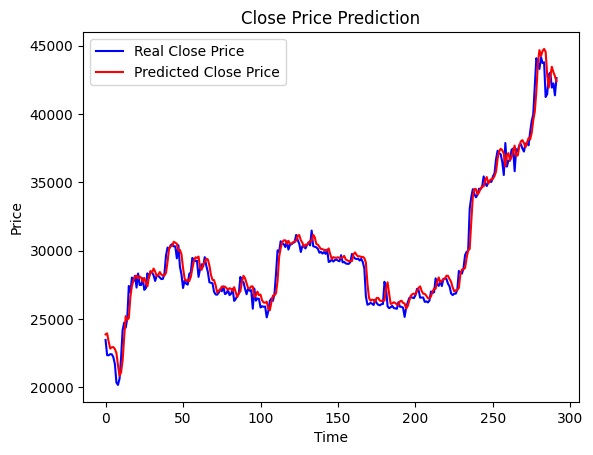

In [26]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


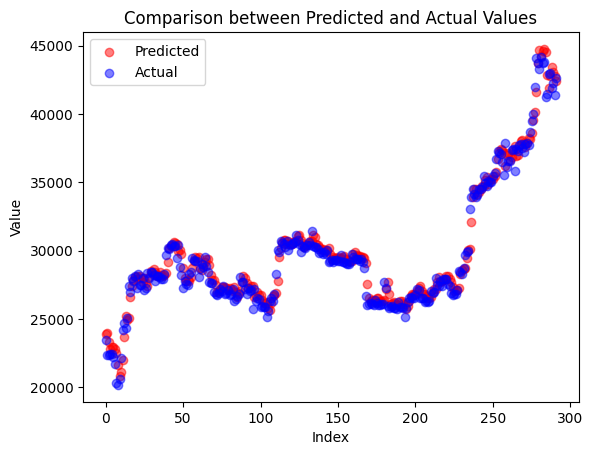

In [27]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


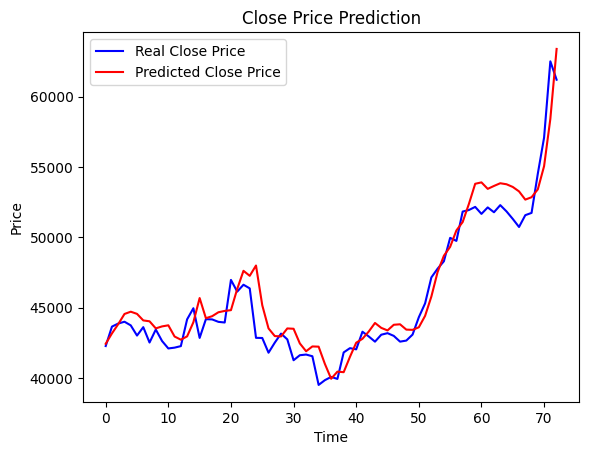

In [28]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

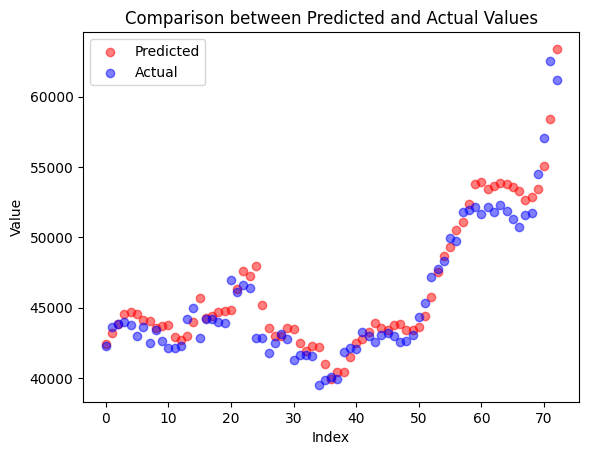

In [29]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [30]:
X_train.shape

(292, 1, 4)

In [31]:
X_test.shape

(73, 1, 4)

In [32]:
features = ["Open", "High", "Low", "Adj Close"]

# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, X_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)
# init the JS visualization code
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)